In [26]:
import numpy as np
import matplotlib.pyplot as plt

From inktime

Parameters for reflectance function (rgbkm.reflectance): 
- K: tuple-like (n channels): Colorant absorption coefficients for wavelength or RGB channels
- S: tuple-like (n channels): Colorant scattering coefficients for wavelength or RGB channels
- D: array ( height x width): Colorant thickness image
- Rg: array (height x width x n) or rgb tuple with shape (3,): Background reflectance image or background color

Returns:   
        refl: array (height x width x n)   
            n-channel reflectance image  


In [2]:
def extract_roi(image, x, y, w, h, line, dark = False):
    """ 
    Extracts region of interest from an image and plots it
    
    Input: 
    - np array of image (H, W, 3)
    - (x,y)= (W,H) top left coordinate of ROI
    - width (w) and height (h) of ROI
    
    Output: 
    ROI and a bounding box used for imaging the ROI within the original image """
    
    roi =  image[y:y+h, x:x+w]
    box = np.copy(image)
    if dark == False:
        intensity = 0
    if dark == True:
        intensity = np.max(image)
    
    box[y:y+line, x:x+w+line] = intensity # top line
    box[y:y+h+line, x:x+line] = intensity # left line
    box[y+h:y+h+line, x:x+w+line] = intensity # bottom line
    box[y:y+h+line, x+w:x+w+line] = intensity # right line
    
    return roi, box

def srgb_to_linear(rgb):
    """
    Confirms small RGB (sRGB) to linear RGB
    """
    rgb = rgb / 255.0
    return np.where(rgb <= 0.04045,
                    rgb / 12.92,
                    ((rgb + 0.055) / 1.055) ** 2.4)

In [7]:
def extract_colors(img, colors, K, iterations = 50, eps = 1e-3, attempts = 10):
    '''Extracts main colors from an image using K_means
    
    Input: 
    - img: Image (H,W,3)
    - colors: RGB values main colors
    - K: Number of main colors
         
    Returns:    
    - out: Image with every pixel replaced by its assigned color 
    - labels_img: Cluster index per pixel (H,W)
        
    '''
    # Transform image to color vectors
    pixels = img.reshape(-1, 3).astype(np.float32)  # (H*W, 3)
    
    #K-means criteria 
    criteria = ( cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 1e-3)

    # K-means clustering: random initialization, initialize 10 times
    compactness, labels, centers = cv2.kmeans(pixels, K, None, criteria, attempts=10, flags=cv2.KMEANS_RANDOM_CENTERS)
    labels_img = labels.reshape(img.shape[:2])  # (H, W)

    # Match clusters to reference colors
    distances = cdist(centers, colors)
    cluster_to_color = np.argmin(distances, axis=1)

    # Reindex clusters so: cluster index == color index
    color_to_cluster = np.zeros(K, dtype=int) 
    for cluster_idx, color_idx in enumerate(cluster_to_color):
        color_to_cluster[color_idx] = cluster_idx

    # Reorder centers to match colors_meanRGB order
    centers = centers[color_to_cluster]

    # Relabel image
    new_labels_img = np.zeros_like(labels_img)
    for new_idx, old_idx in enumerate(color_to_cluster):
        new_labels_img[labels_img == old_idx] = new_idx

    labels_img = new_labels_img

    # Refill image using aligned indices
    out = np.zeros_like(img, dtype=np.float32)
    for color_idx in range(K):
        out[labels_img == color_idx] = colors_meanRGB[color_idx]

    return out, labels_img


In [75]:
def sk_ratio(R_inf):
    # Calculates S/K from R_inf using Kubelka-Munk
    return (2*R_inf)/((1-R_inf)**2)

def refl(R_inf, Rg, labels, D, K_scale, S_scale):
    """
    Calculates reflectance of the entire image using Kubelka-Munk
    
    Input:
    - R_inf: list with R, G, B values of opaque inkts
    - Rg = background reflectance (R,G,B) or (H,W,3)
    - labels: cluster label for each pixel
    - D: thickness array (H,W)
    _ K and S_scale: scales absorption and scattering without changing relative RGB

    Output:
    R_total: Total reflectance
    masks: masks different areas
    """
    
    masks = [labels == 0] # Mask of the background
    R_total = np.full((height, width, 3), Rg, dtype=np.float32)

    for i, R in enumerate(Rinf):
    
        mask = labels == (i+1)
        masks.append(mask)

        # Initialize S and K
        S0 = np.array([1.0, 1.0, 1.0], dtype=np.float32) # Estimation
        K0  = S0 / sk_ratio(R)

        # Parametrisation
        K = K0 * K_scale      
        S = S0 * S_scale      
    
        # Reflectance
        Refl = rgbkm.reflectance(K, S, D, Rg)
        R_total[mask] = Refl[mask]
        
    return R_total, masks

In [177]:
def build_lut(K, S, Rg, D_vals):
    """
    Builds thickness map look-up table
    
    Input:
    - K, S for a color
    - D_vals: (nD,) D values
    - Rg: background
    
    Returns:
        R_lut: (nD, 3) reflectance samples
    """
    
    h, w = 1, 1  # dummy spatial dims for rgbkm.reflectance
    R_lut = []   # reflectance for D_vals

    for D in D_vals:
        D_img = np.full((h, w), D, dtype=np.float32) # create thickness pixel (1,1)
        R = rgbkm.reflectance(K, S, D_img, Rg) # R(D) (1,1,3)
        R_lut.append(R[0, 0]) # Flatten R(D) and add to look-up table

    return np.array(R_lut)


def invert_thickness_lut(R_pixels, R_lut, D_vals):
    
    """
    Input:
    - R_pixels: (N, 3) (N = number of pixels in specific pigment)
    - R_lut: (nD, 3) reflectance samples
    - D_vals: Thickness samples

    Output:
    - optimal D values
    """

    # Calculate distance in RGB space between image pixels and values in look-up table
    distances = cdist(R_pixels, R_lut)   # (N, nD) 

    # Find minimum distance (= distance that comes closest to R(D) = Rp)
    idx = np.argmin(distances, axis=1)
    return D_vals[idx]

def invert_thickness_image(img, labels, K_list, S_list, Rg, D_max=10.0, nD=512):
    
    """
    Input:
    - img: image
    - labels: cluster label for each pixel
    - K_list, S_list: of the form K = ([Kr, Kg, Kb], ...) 
    - Rg = background reflectance (R,G,B) or (H,W,3)
    - D_max = maximum thickness
    - nD = size of look up table

    Output:
    - Thickness map (H,W)
    """
    
    H, W, _ = img.shape
    D_map = np.zeros((H, W), dtype=np.float32) # thickness map (H,W)

    # D values for look-up table
    D_vals = np.linspace(0, D_max, nD)

    # iterate over pigments 
    for i, (K, S) in enumerate(zip(K_list, S_list)):
        mask = labels == (i + 1) # color mask
        if not np.any(mask):
            continue

        # Build thickness look-up table for this pigment
        R_lut = build_lut(K, S, Rg, D_vals)

        # Select pigment in image
        R_pixels = img[mask]

        # Find optimal distances for all pixels assigned to this pigment
        D_pixels = invert_thickness_lut(R_pixels, R_lut, D_vals)

        # Store in thickness map
        D_map[mask] = D_pixels

    return D_map



### Load in image

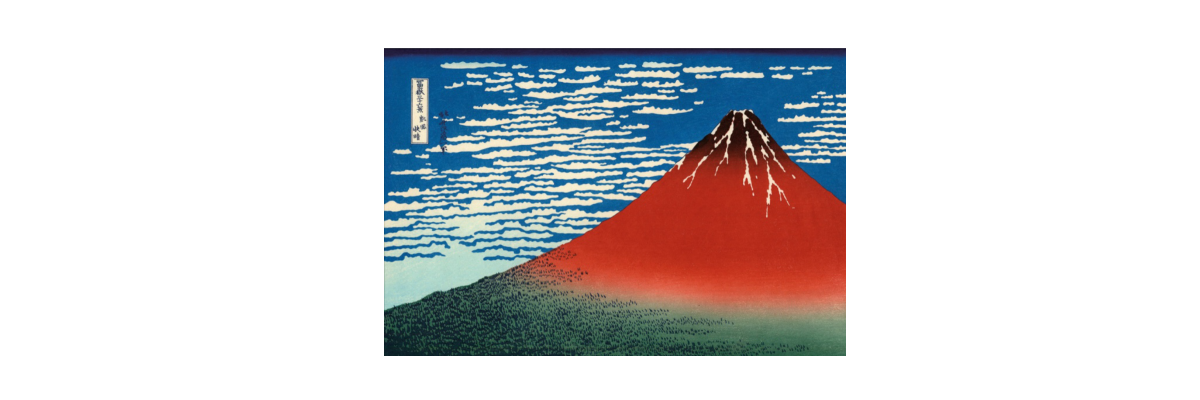

In [29]:
# Load in Red Fuji
img = Image.open("red_fuji.jpg") # Shape (x,y,RGB)
img = np.array(img)/255.0

height, width, _ = img.shape

# Plot
fig, ax = plt.subplots(1, figsize = (12,4))
ax.imshow(img)
ax.axis('off')
plt.show()

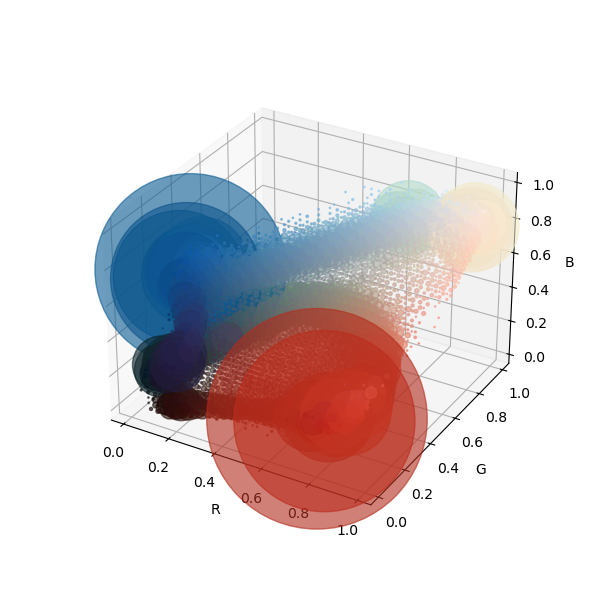

In [31]:
%matplotlib widget
rgb = img.reshape(-1, 3)

if rgb.max() > 1:
    rgb = rgb / 255.0

# Number of bins per channel
bins = 32

hist, edges = np.histogramdd(rgb, bins=(bins, bins, bins), range=((0,1),(0,1),(0,1)))

# Get bin centers
centers = [0.5 * (e[:-1] + e[1:]) for e in edges]
R, G, B = np.meshgrid(*centers, indexing='ij')

# Flatten
R = R.ravel()
G = G.ravel()
B = B.ravel()
counts = hist.ravel()

mask = counts > 0

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    R[mask],
    G[mask],
    B[mask],
    c =np.stack([R[mask], G[mask], B[mask]], axis=1),
    s = counts[mask],
    alpha=0.6
)

ax.set_xlabel("R")
ax.set_ylabel("G")
ax.set_zlabel("B")

plt.show()
